In [11]:
## IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import copy

from keras import models
from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
# from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from PIL import Image

import imblearn

import os

In [2]:
## FONCTIONS ET VARIABLES UTILES

# def read_text_file(file_path):
#     with open(file_path, encoding='ISO-8859-1') as f:
#         lines = f.readlines()
#         return lines
        
def read_number_line(some_line):
    return [float(s) for s in some_line.split()]

my_dpi = np.sqrt(1920**2 + 1080**2)/17.3 #dpi de l'écran

On tente tout d'abord une approche par clustering pour séparer les signaux bruités des autres de manière non supervisée:

In [3]:
## IMPORT DES DONNEES

train_folder = "C:/Users/victo/stage_navier_jupyter/data_eurotunnel/data_png/training_png/"
val_folder = "C:/Users/victo/stage_navier_jupyter/data_eurotunnel/data_png/validation_png/"

pk_folder_train = "1775_20190128/"
pk_folder_val = "4250_20190225/"

train_path = train_folder + pk_folder_train
val_path = val_folder + pk_folder_val

In [4]:
## TEST SUR UNE IMAGE QU'ON MODIFIE DE 4 FACONS

test_list = []

img_path = train_path + "_D_001_vitesse.png"
img = image.load_img(img_path, target_size=(600, 400))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
x = np.divide(x, 255.)
test_list.append(x)

# print(x[0, 100, 295, 1])

img_path_2 = train_path + "_D_002_vitesse.png"
img = image.load_img(img_path, target_size=(600, 400))
y = image.img_to_array(img)
y = y.reshape((1,) + y.shape)
y = np.divide(y, 255.)
test_list.append(y)

img_path_3 = train_path + "_D_003_vitesse.png"
img = image.load_img(img_path, target_size=(600, 400))
z = image.img_to_array(img)
z = z.reshape((1,) + z.shape)
z = np.divide(z, 255.)
test_list.append(z)

test_array = np.array(test_list)

xmpl = test_array[1]
print(xmpl[0, 372, 257, 2])

1.0


buffer

In [5]:
## ON TEST SUR UN DOSSIER ENTIER POUR VOIR LE TEMPS DE CALCUL

x_train = []

os.chdir(train_folder+pk_folder_train)
for file_name in os.listdir():
    if file_name.endswith("fourier.png"):
        img_path = train_folder + pk_folder_train + "/" + file_name
        img = image.load_img(img_path, target_size=(600, 400))
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)
        x = np.divide(x, 255.)
        x_train.append(x)
        
x_train_array = np.array(x_train)
example = x_train_array[42]
print(example[0, 372, 257, 2])

prod = 1
for i in range(1, len(x_train_array.shape)):
    prod *= x_train_array.shape[i]
    print(prod)
x_train_array = np.reshape(x_train_array, (x_train_array.shape[0], prod))

print(x_train_array.shape)

kmeans_2 = KMeans(n_clusters=2, n_init=20)
y_pred_kmeans_2 = kmeans_2.fit_predict(x_train_array)

print(y_pred_kmeans_2)



1.0
1
600
240000
720000
(162, 720000)
[0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0
 1 0 0 0 1 0 0 1 1 1 1 1 1 0]


On évalue comment s'est fait ce clustering en affichant d'abord toutes les images de la classe "1", puis toutes celles de la classe "0"

In [16]:
##AFFICHAGE DE LA CLASSE "1"

# print(y_pred_kmeans_2[0]) #c'est bien un 1
# print(len(y_pred_kmeans_2)) #c'est bien 162

one_ind = []
for i in range(len(y_pred_kmeans_2)):
    if y_pred_kmeans_2[i] == 1:
        one_ind.append(i)

print(len(one_ind)) #62

one_ind_str = [str(x).zfill(3) for x in one_ind]

print(one_ind_str[42]) #123

os.chdir(train_folder+pk_folder_train)
for file_name in os.listdir():
    if file_name.endswith("_fourier.png"):
        prefix = file_name[:3] #_D_ ou _G_
        infix = file_name[3:6] #numéro du blochet
        
        if prefix == '_D_':
            if infix in one_ind_str:
                img = mpimg.imread(train_folder+pk_folder_train+file_name)
                imgplot = plt.imshow(img)
                plt.show()
        
        elif prefix == '_G_':
            nfx = int(infix)
            nfx += (len(y_pred_kmeans_2) // 2)
            infix = str(nfx) #ceux de gauche sont lus après tous ceux de droite
            if infix in one_ind_str:
                img = mpimg.imread(train_folder+pk_folder_train+file_name)
                imgplot = plt.imshow(img)
                plt.show()

##CONDENSE TOUT EN 1 IMAGE POUR VOIR COMMENT IL DISCRIMINE EN CLASSES
# for file_name in os.listdir():
#     if file_name.endswith("_fourier.png"):
#         prefix = file_name[:3] #_D_ ou _G_
#         infix = file_name[3:6] #numéro du blochet
        
#         k = 0 #compteur allant de 1 au nombre d'images dans la classe
        
#         background = Image.open(train_folder+"white_background.png").convert('RGBA')
        
#         if prefix == '_D_':
#             if infix in one_ind_str:
#                 k += 1
#                 img = Image.open(train_folder+pk_folder_train+file_name).convert('RGBA')
#                 background = Image.blend(background, img, alpha=1./k)
                
#         elif prefix == '_G_':
#             nfx = int(infix)
#             nfx += (len(y_pred_kmeans_2) // 2)
#             infix = str(nfx) #ceux de gauche sont lus après tous ceux de droite
#             if infix in one_ind_str:
#                 k += 1
#                 img = Image.open(train_folder+pk_folder_train+file_name).convert('RGBA')
#                 background = Image.blend(background, img, alpha=1./k)
        
#         background.save(train_folder+pk_folder_train+"kmeans_2_class_1.png", "PNG")
        
# background.show()


62
123


100
050


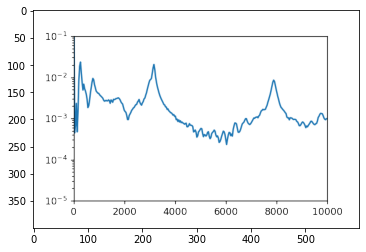

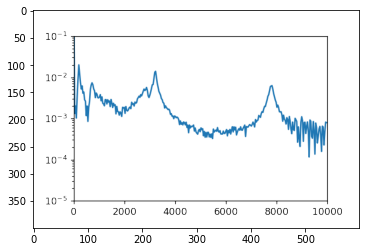

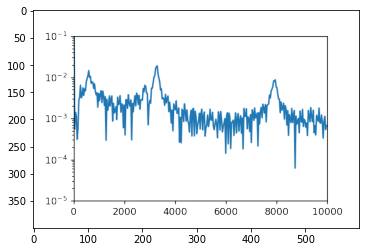

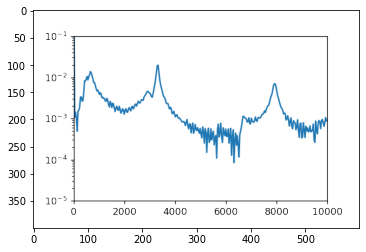

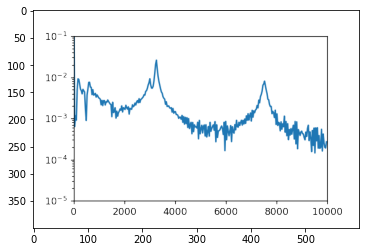

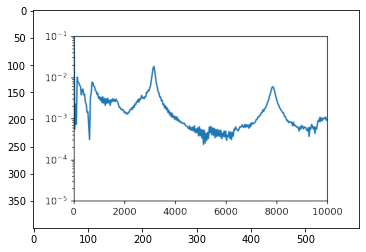

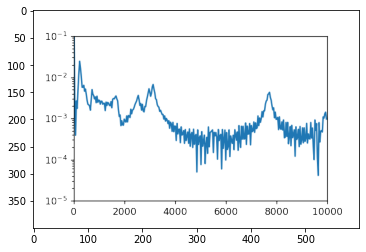

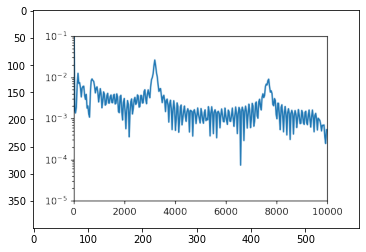

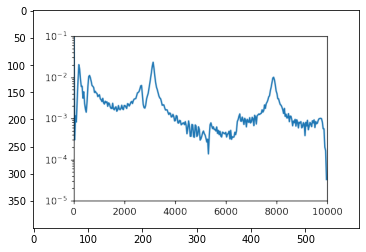

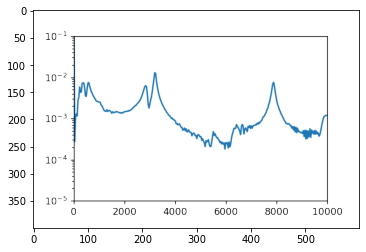

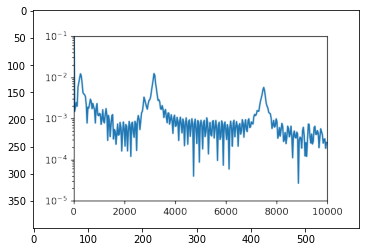

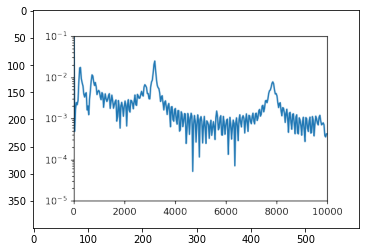

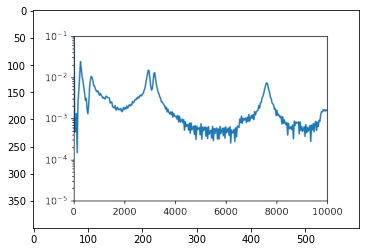

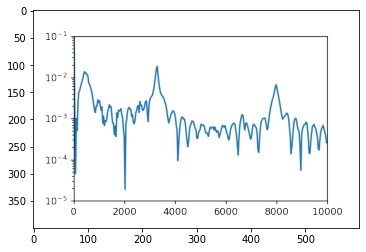

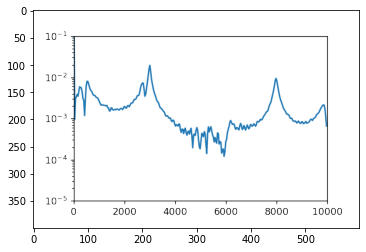

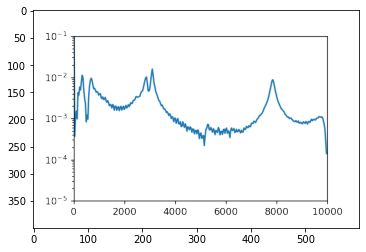

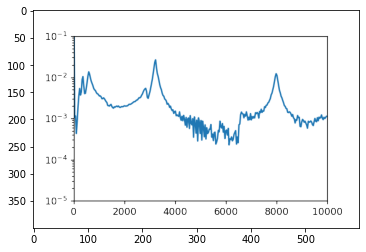

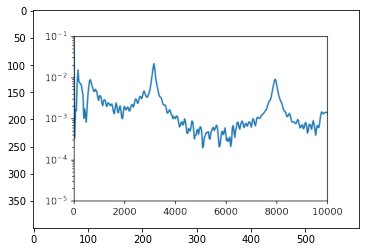

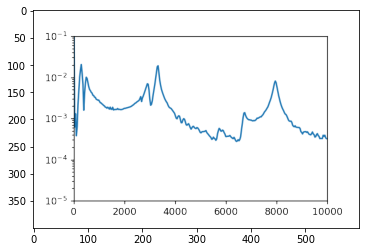

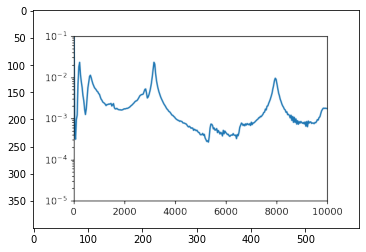

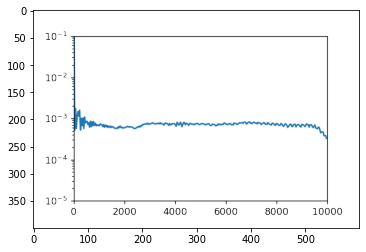

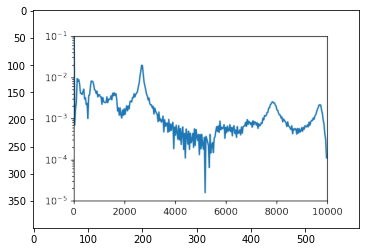

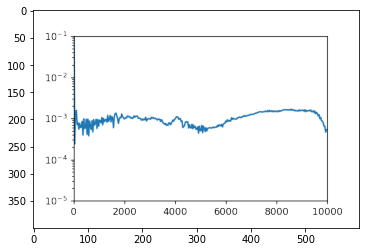

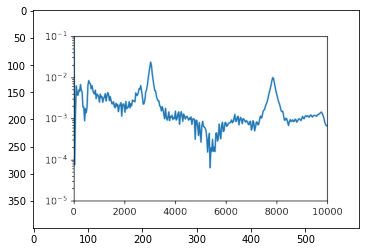

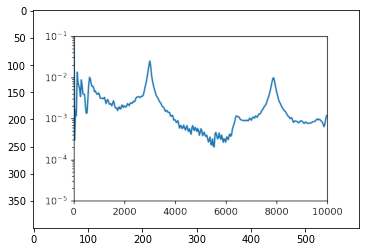

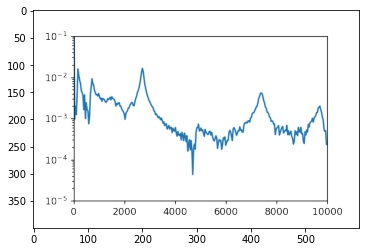

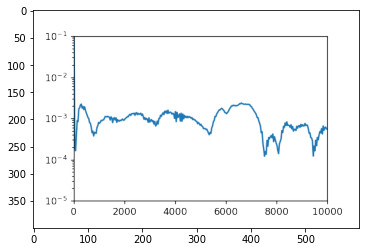

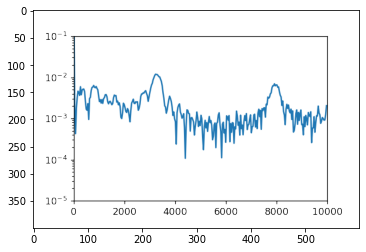

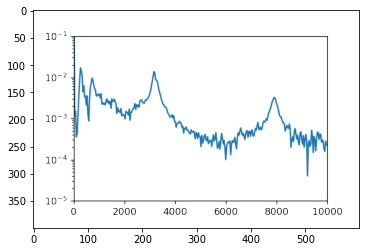

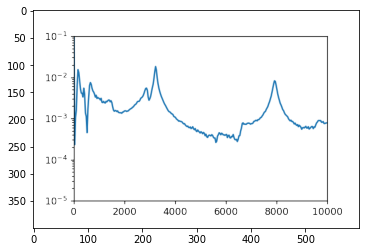

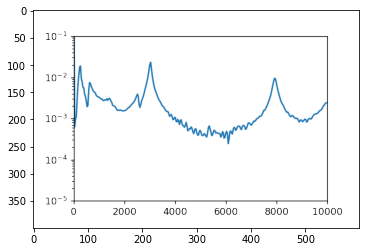

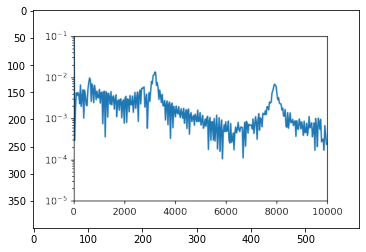

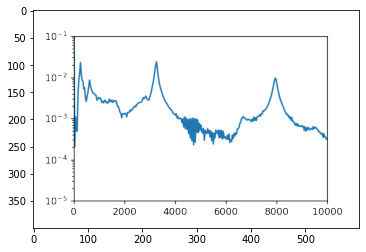

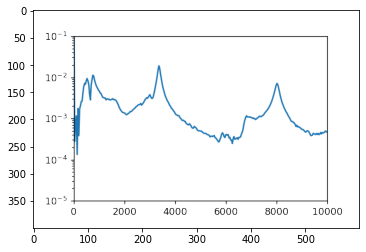

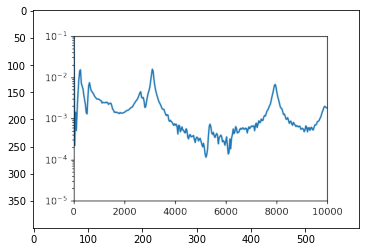

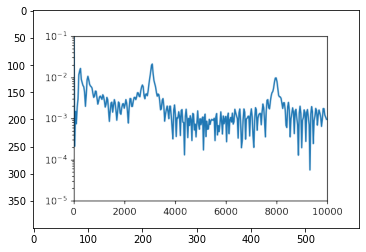

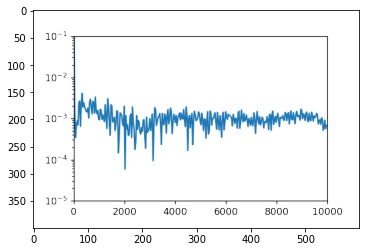

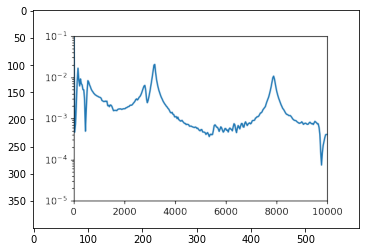

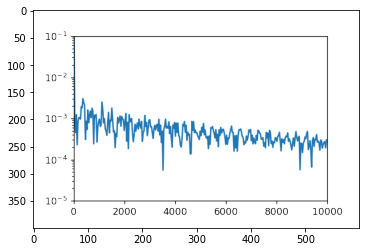

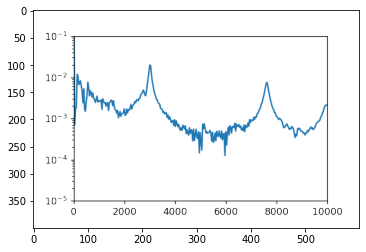

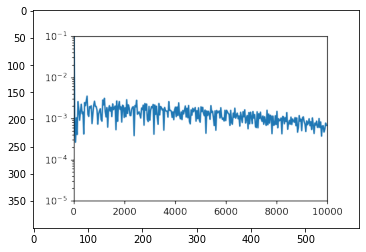

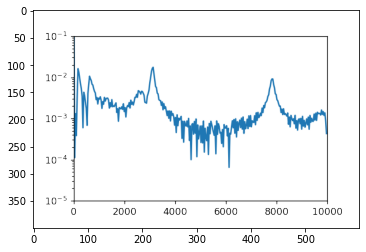

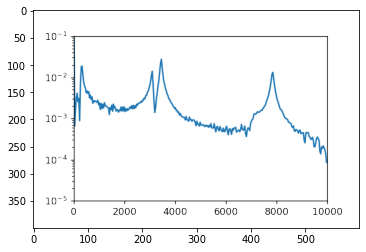

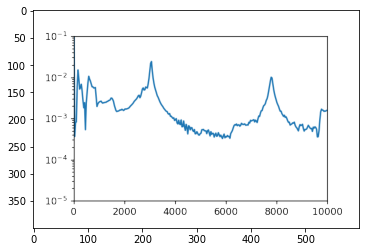

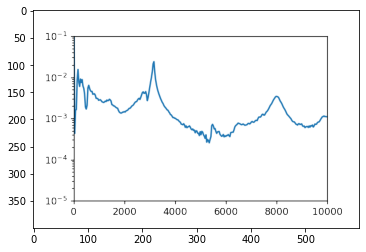

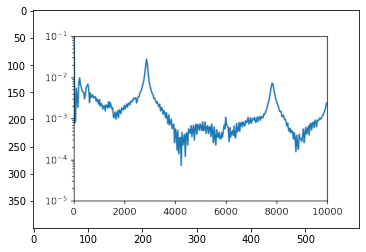

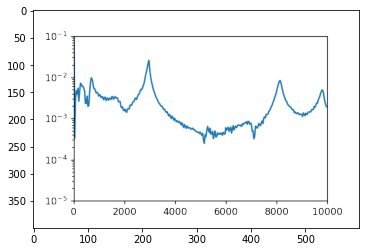

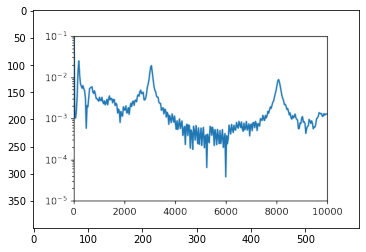

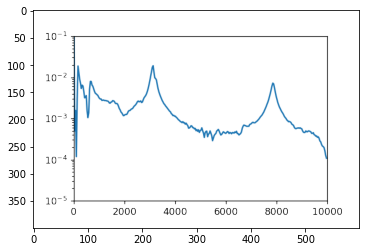

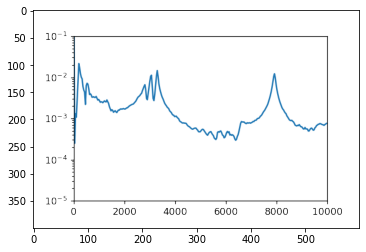

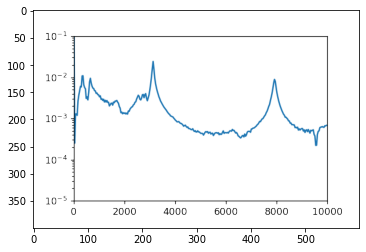

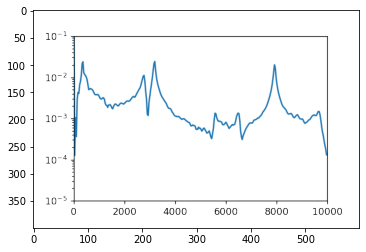

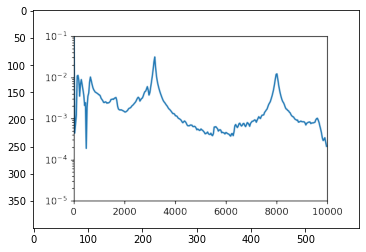

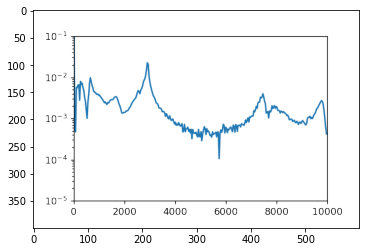

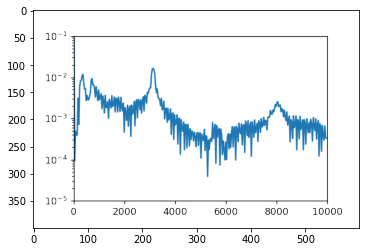

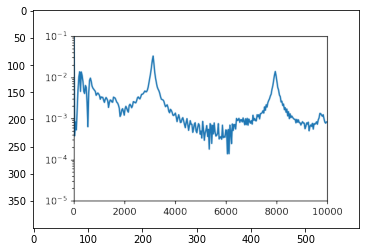

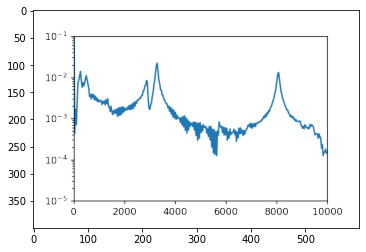

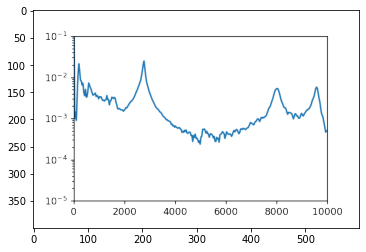

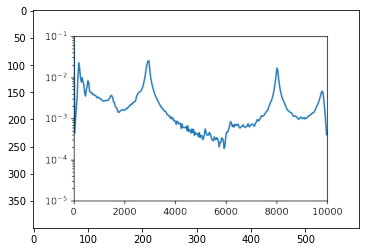

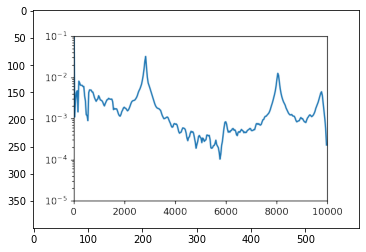

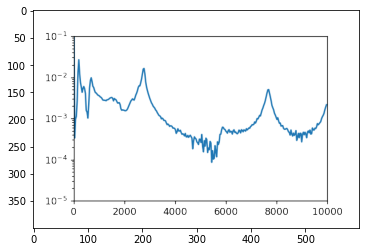

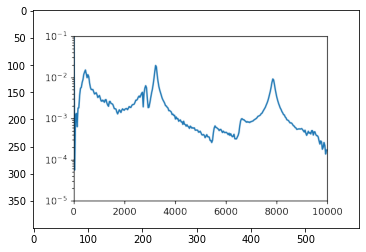

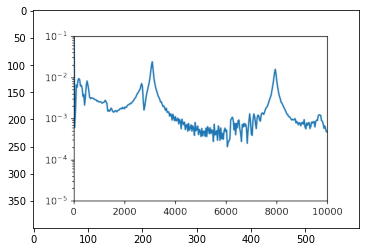

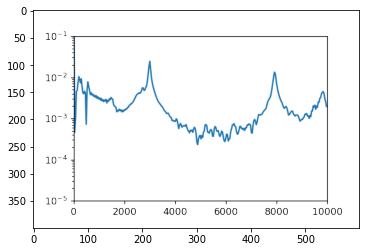

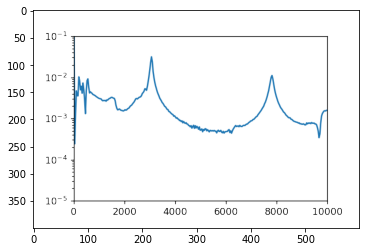

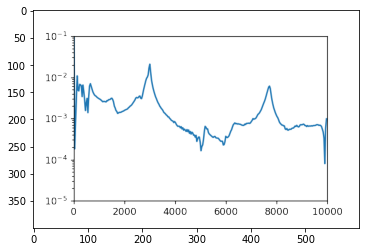

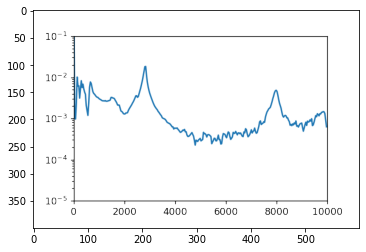

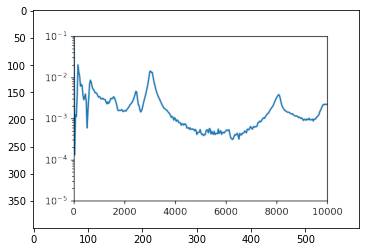

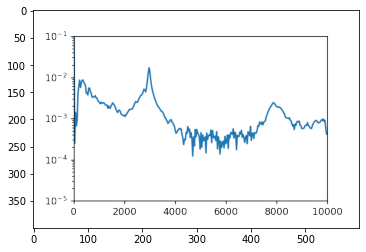

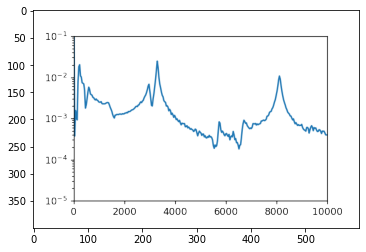

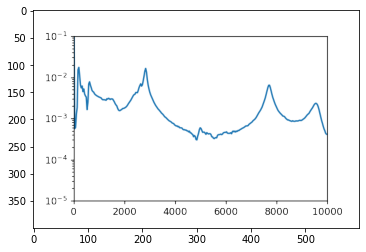

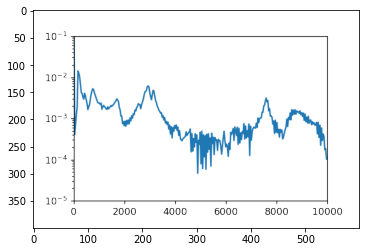

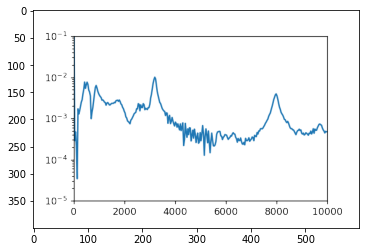

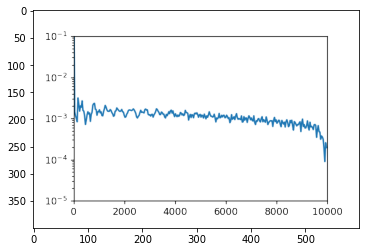

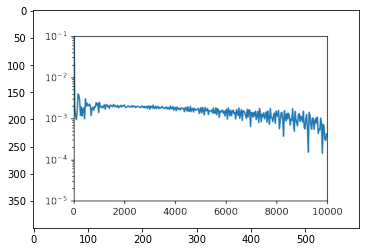

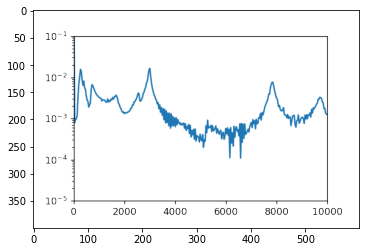

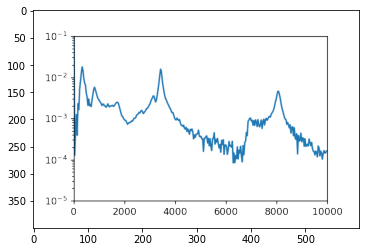

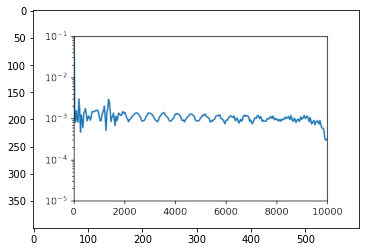

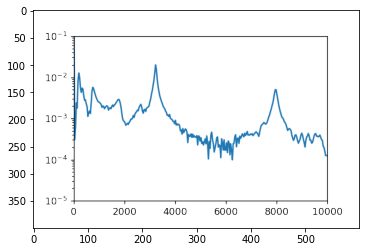

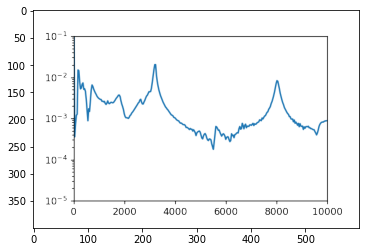

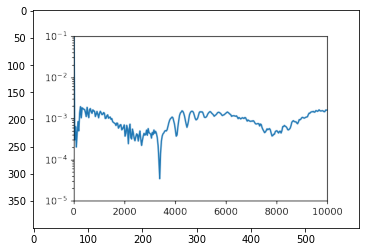

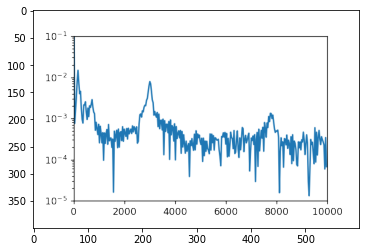

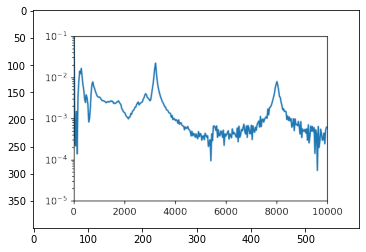

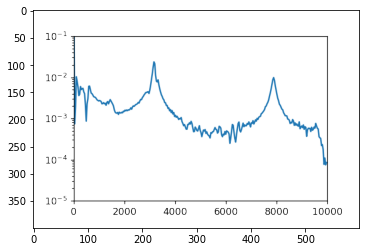

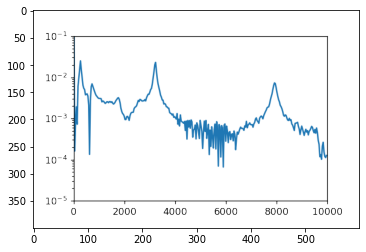

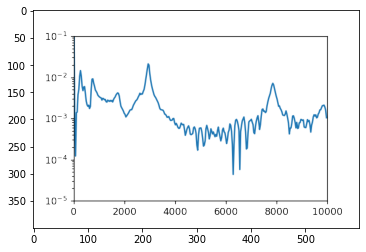

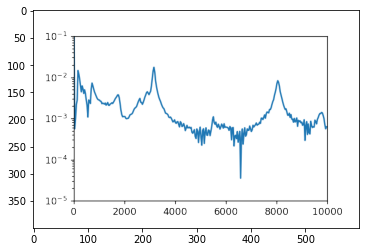

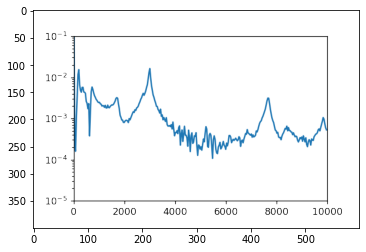

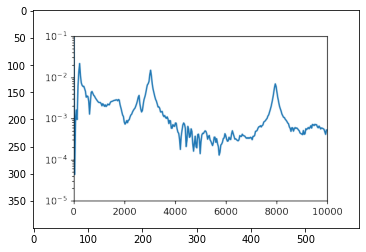

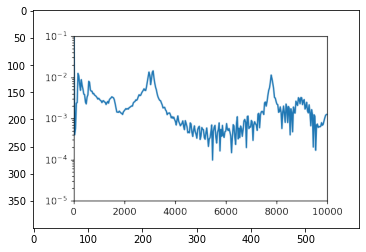

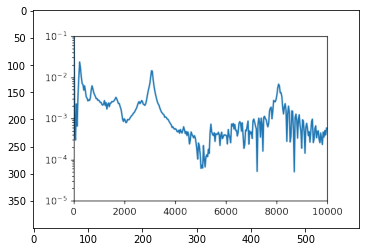

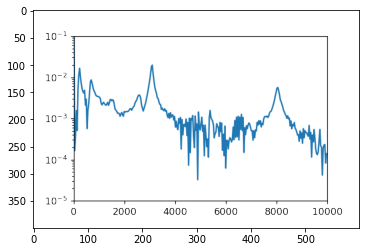

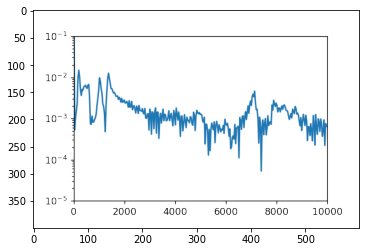

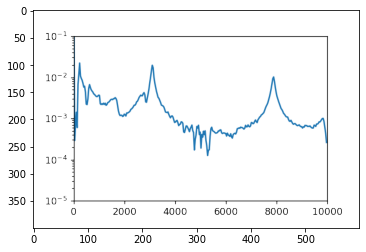

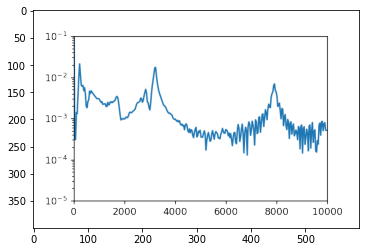

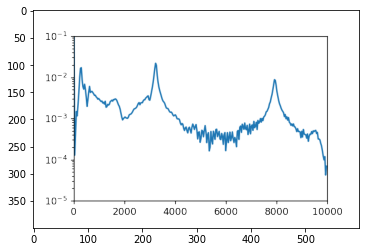

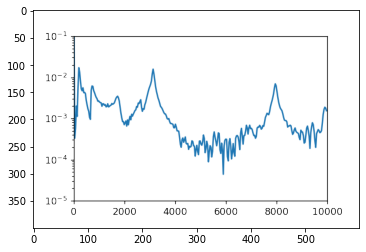

In [9]:
##AFFICHAGE DE LA CLASSE "0"

# print(y_pred_kmeans_2[0]) #c'est bien un 1
# print(len(y_pred_kmeans_2)) #c'est bien 162

zero_ind = []
for i in range(len(y_pred_kmeans_2)):
    if y_pred_kmeans_2[i] == 0:
        zero_ind.append(i)

print(len(zero_ind)) #100

zero_ind_str = [str(x).zfill(3) for x in zero_ind]

print(zero_ind_str[42]) #050

os.chdir(train_folder+pk_folder_train)
for file_name in os.listdir():
    if file_name.endswith("_fourier.png"):
        prefix = file_name[:3] #_D_ ou _G_
        infix = file_name[3:6] #numéro du blochet
        
        if prefix == '_D_':
            if infix in zero_ind_str:
                img = mpimg.imread(train_folder+pk_folder_train+file_name)
                imgplot = plt.imshow(img)
                plt.show()
        
        elif prefix == '_G_':
            nfx = int(infix)
            nfx += (len(y_pred_kmeans_2) // 2)
            infix = str(nfx) #ceux de gauche sont lus après tous ceux de droite
            if infix in zero_ind_str:
                img = mpimg.imread(train_folder+pk_folder_train+file_name)
                imgplot = plt.imshow(img)
                plt.show()

CONCLUSIONS VITESSE:


Le clustering n'est pas super bien fait pour séparer des signaux bruités et non bruités en K=2 classes direct. Y'a un début mais c'est pas encore ça. On va faire pareil avec 3 ou 4 classes et voir si une classe "bruitée" se dégage.

CONCLUSIONS FOURIER:

C'est encore loin d'être parfait mais on dirait que les signaux sains se retrouvent significativement plus dans la classe 1, et le "nimporte quoi" est surtout dans la classe 0. On regarde ce que ça donne pour K=3 ou 4 mais y'a moyen que ça donne qqch de bien.


In [ ]:
# ## ON AGREGE TOUTES LES IMAGES DE VITESSE DANS UNE DB

# x_train = []

# os.chdir(train_folder)
# for folder in os.listdir():
#     for file_name in os.listdir(train_folder + folder):
#         if file_name.endswith("vitesse.png"):
#             img_path = train_folder + folder + "/" + file_name
#             img = image.load_img(img_path, target_size=(600, 400))
#             x = image.img_to_array(img)
#             x = x.reshape((1,) + x.shape)
#             x = np.divide(x, 255.)
#             x_train.append(x)

# x_train_array = np.array(x_train)
# example = x_train_array[42]
# print(example[0, 372, 257, 2])

# #pour l'instant, comme on a pas de labels, on regarde "à la main" les classes générées automatiqt

# #K = 2
# kmeans_2 = KMeans(n_clusters=2, n_init=20, n_jobs=4)
# y_pred_kmeans_2 = kmeans_2.fit_predict(x_train_array)

# #K = 3
# kmeans_3 = KMeans(n_clusters=3, n_init=20, n_jobs=4)
# y_pred_kmeans_3 = kmeans_3.fit_predict(x_train_array)

